In [160]:
%load_ext autoreload
%autoreload 2

#standard imports
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

#rl book imports
import rl
from rl.markov_decision_process import MarkovDecisionProcess
from rl.markov_process import State, MarkovProcess, NonTerminal, Terminal

from typing import (Callable, Dict, Generic, Iterator, Iterable, List,
                    Mapping, Optional, Sequence, Tuple, TypeVar, overload)

from rl.distribution import Categorical, Distribution, Constant, Choose
from rl.policy import Policy
from rl.monte_carlo import epsilon_greedy_policy, greedy_policy_from_qvf, glie_mc_control, mc_prediction
from rl.function_approx import LinearFunctionApprox, AdamGradient
from rl.td import glie_sarsa, q_learning


#custom imports 
import utils as u
import data as dat
import mdp_agent as ag
import baseline_policies as bp
import q_plots as qp
import backtest as btest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#  Predict V for OU

In [161]:
mu=100
sigma = 30
train, test = dat.build_simulated_train_test(N=10,mu=mu,sigma=sigma)
u.plot_plotly_multiple(train)

In [162]:
u.plot_plotly(test)

In [163]:
mrp_buy = trader.apply_policy(bp.BuyAndHold())

In [164]:
initial_state = trader.generate_start_state("train")
traces = mrp_buy.reward_traces(initial_state)

In [165]:
ffs = [
    lambda x : 1,
    lambda x : x.state["Spot"]
]

approx_0 = LinearFunctionApprox.create(feature_functions=ffs)

vfs = mc_prediction(
    traces,
    approx_0,
    0.9,
    1e-6
)

num_iter = 1000

final_v = None

for i,vf in enumerate(vfs):
    if i>=num_iter:
        break 

    final_v = vf


print("=== weights ===")
print(final_v.weights.weights)


=== weights ===
[ 0.84131257 -0.00847001]


In [166]:
state_dicts =  [NonTerminal({
            "Spot" :  s,
            "position" : 1,
            "date" : "2020-01-01",
            "data" : test,
            "lookback":10,
            "time index":0
        }) for s in np.arange(70,110,0.01)]

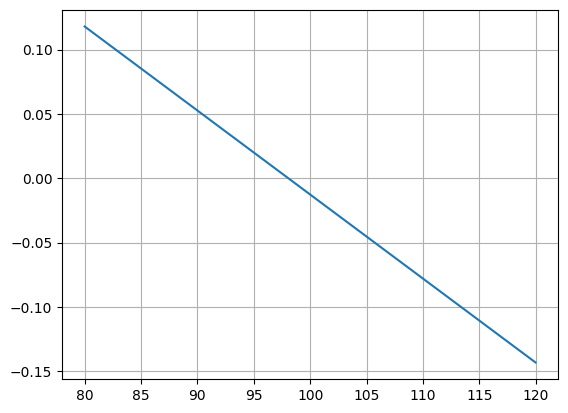

In [139]:
plt.plot(np.arange(100-20,100+20,0.01),[final_v(s) for s in state_dicts])
plt.grid()

In [104]:
ffs = [
    lambda x : 1,
    lambda x : x.state["Spot"]
]

approx_0 = LinearFunctionApprox.create(feature_functions=ffs)

vfs = mc_prediction(
    traces,
    approx_0,
    0.9,
    1e-6
)

num_iter = 1000

final_v = None

for i,vf in enumerate(vfs):
    if i>=num_iter:
        break 

    final_v = vf


print("=== weights ===")
print(final_v.weights.weights)

=== weights ===
[ 0.78060712 -0.00775521]


In [134]:
ffs = [
    lambda x : 1,
    lambda x : x.state["Spot"]
]

approx_0 = LinearFunctionApprox.create(feature_functions=ffs)

vfs = mc_prediction(
    traces,
    approx_0,
    0.5,
    1e-6
)

num_iter = 10000

final_v = None

for i,vf in enumerate(vfs):
    if i>=num_iter:
        break 
    if i%50==0:
        print(vf.weights.weights)
       
        default_state_dict = {
            "Spot" : 90,
            "position" : 1,
            "date" : "2020-01-01",
            "data" : test,
            "lookback":10,
            "time index":0
        }

        print("90")
        print(vf(NonTerminal(default_state_dict)))

        print("110")
        default_state_dict["Spot"] = 110
        print(vf(NonTerminal(default_state_dict)))

        print("======")

    final_v = vf


print("=== weights ===")
print(final_v.weights.weights)

[0. 0.]
90
0.0
110
0.0
[ 0.03014192 -0.00083471]
90
-0.044981985480372175
110
-0.06167618632307756
[ 0.07224779 -0.0002952 ]
90
0.04568000149236798
110
0.03977604912082688
[ 0.11696846 -0.0008123 ]
90
0.04386158928840223
110
0.02761561755073945
[ 0.14769522 -0.00175858]
90
-0.010577139916668005
110
-0.04574877582986593
[ 0.17696111 -0.0005564 ]
90
0.12688544094416535
110
0.11575751505347984
[ 0.19993062 -0.00114334]
90
0.09703010469119058
110
0.07416332240428308
[ 0.21071393 -0.00064155]
90
0.15297430929449693
110
0.14014328293744815
[ 0.23449038 -0.00317151]
90
-0.05094509906336805
110
-0.11437520558337215
[ 0.26250338 -0.00268667]
90
0.020703113742474744
110
-0.03303027818249299
[ 0.29670495 -0.00285146]
90
0.040073919245778154
110
-0.016955198962182755
[ 0.32285441 -0.00281808]
90
0.06922708007322981
110
0.012865451061990918
[ 0.35250688 -0.00332061]
90
0.05365223857687687
110
-0.012759903317117788
[ 0.38512611 -0.00358895]
90
0.062120303500139896
110
-0.009658763803325438
[ 0.41514

# Now that we have V, include it as feature

In [168]:
trader = ag.Trading(train,test,lookback=0)

ffs = [

    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == -1 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == 0 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==0)and (x[1] == 1 )) else 0,

    lambda x: 1 if ((x[0].state["position"]==1)and (x[1] == -1 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==1)and (x[1] == 0 )) else 0,

    lambda x: 1 if ((x[0].state["position"]==-1)and (x[1] == 0 )) else 0,
    lambda x: 1 if ((x[0].state["position"]==-1)and (x[1] == 1 )) else 0,

    lambda x:  final_v(x[0]) if ((x[0].state["position"]==0)and (x[1] == -1 )) else 0,
    lambda x:  final_v(x[0]) if ((x[0].state["position"]==0)and (x[1] == 0 )) else 0,
    lambda x:  final_v(x[0]) if ((x[0].state["position"]==0)and (x[1] == 1 )) else 0,

    lambda x:  final_v(x[0]) if ((x[0].state["position"]==1)and (x[1] == -1 )) else 0,
    lambda x:  final_v(x[0]) if ((x[0].state["position"]==1)and (x[1] == 0 )) else 0,

    lambda x:  final_v(x[0]) if ((x[0].state["position"]==-1)and (x[1] == 0 )) else 0,
    lambda x:  final_v(x[0]) if ((x[0].state["position"]==-1)and (x[1] == 1 )) else 0,
  
]

q_approx = LinearFunctionApprox.create(feature_functions=ffs)


In [169]:
qvfs_mc = glie_mc_control(
    trader,
    trader.generate_start_state("train"),
    q_approx,
    0.5,
    lambda k: 1/k
)

In [173]:
num_iter = 10000
final_qvf = None
for i,qvf in enumerate(qvfs_mc):
    if i%100==0:
        print(i)
    if i>=num_iter:
        break
    final_qvf = qvf

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [171]:
qanalysis = qp.QAnalyzer(test,final_qvf)
qanalysis.plot_snapshot()

In [172]:
trading_policy  = greedy_policy_from_qvf(final_qvf, lambda x : [-1,0,1])
bt = btest.Backtester(trader,trading_policy)
bt.summary()

/Users/mehdi/Desktop/cme241/RL_Project/utils.py:96: FutureWarning:

Argument `closed` is deprecated in favor of `inclusive`.

